In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from SpectralAnalysis import *
import numpy as np
import pandas as pd
from bokeh.io import output_notebook
import matplotlib.pyplot as plt

output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


BokehJS successfully loaded.

# SpectralAnalysis showcase

I've written a library for regular plotting and curve fitting that is much, much nicer than the FittingRoutines module. In this notebook I'll be showing off (I guess in a README-esque way) of how all the functions should be called as I've written them.

The first notable thing is a class Model, which will house the functions used to fit our sets of data. The advantage of doing it this way is that necessary variables will be detected, and reported back to the user to remind them what is required.

To create a Model instance, we give it a string name:

In [112]:
testmodel = Model("Test")      # set up a test model with linear fit

 Please call SetFunction(Function)


It'll then remind you to set a function, because as it stands it's only nominally a function. We can either define our own function within the notebook, or use one of the preset functions I've written.

To start off, let's make it a straight line with the equation

$$ y = mx + c $$

In [113]:
testmodel.SetFunction(Linear)

 Initialised variable dictionary:
{'Gradient': None, 'Offset': None}


The instance will automagically detect what variables are required for the function, providing the function you gave it is a one-liner (only has return) just because of the way python works. In this case, we need the gradient and offset values which we can set by sending a dictionary along its way

In [114]:
testmodel.SetVariables({"Gradient": 5., "Offset": 2.})            # Dictionary with variables

That's all we need to do to define a Model instance! Let's test it out by creating some fake linear data.

In [115]:
x = np.linspace(0,10,20)
Noise = np.random.rand(20)
y = Linear(x, 6., 3.) + Noise            # Generate some data to fit to

Now I've also written a function that will package some xy data in the correct format for curve fitting. This is done by using the FormatData() function.

In [116]:
df = FormatData(x, y)

df is now a pandas dataframe, where x is stored as the index and y is a column called "Y Range", just for internal consistency.

Now we're ready to fit the data by calling the function FitModel. The input parameters for this is a reference to the dataframe holding the target data, as well as a reference to the Model instance. What it returns are:

1. Optimised parameters
2. Fit report
3. Fitted curves, including the original data
4. Covariance matrix

In [119]:
popt, report, fits, pcov = FitModel(df, testmodel)

 Curve fitting with:	Test
 Boundary Conditions:
([-inf, -inf], [inf, inf])
 Initial parameters:
{'Gradient': 5.0, 'Offset': 2.0}
                 0
Gradient  5.993004
Offset    3.572731


And it worked! Now we can call the plotting interface to show us the results. For this, I've written a function called PlotData(). The dataframe input is formatted such that x is the index, and will work with up to 11 columns. A keyword Interface will also let you choose between using matplotlib (good for static plots, saves space and time) and bokeh (interactive and pretty, slow). Another interesting argument is Labels, which is a dictionary for specifying the axes labels and whatnot. If it is left unspecified, it will just plot without labels.

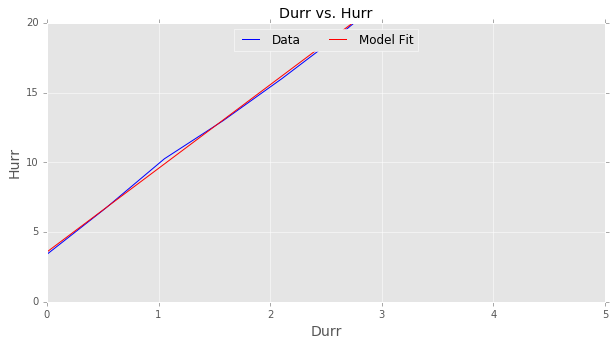

In [120]:
Labels = {"X Label": "Durr",
          "Y Label": "Hurr",
          "Title": "Durr vs. Hurr",
          "X Limits": [0, 5],
          "Y Limits": [0, 20],}
PlotData(fits, Interface="pyplot", Labels=Labels)

---

A more advanced function, such as a Gaussian is shown below. The procedure I went through is exactly the same as above.

The one thing I did differently was include boundary conditions for the curve fitting. This is done by calling the Model.SetBounds() method, where the input is shown below. Another thing demonstrated below is the use of the Spectrum class. I've written it to store and reference data, but admittedly haven't gone very far with it beyond storing the spectra as an attribute.

---

In [121]:
FC063b = Spectrum("./FC063b_sub_KER.dat")

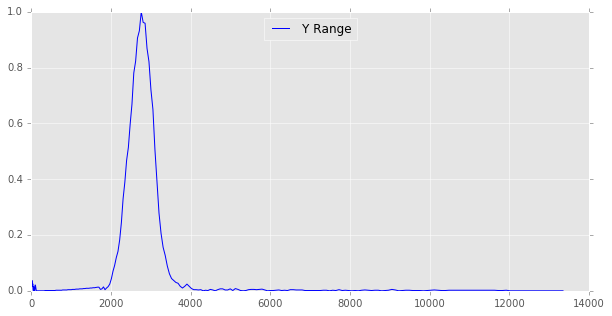

In [196]:
FC063b.PlotAll()

In [122]:
GaussianModel = Model("Gaussian")
GaussianModel.SetFunction(GaussianFunction)

 Please call SetFunction(Function)
 Initialised variable dictionary:
{'Width': None, 'Amplitude': None, 'Centre': None}


In [123]:
GaussianModel.SetVariables({"Amplitude": 50., "Centre": 2500., "Width": 300.})
Boundaries = ([0., 2400., 200.], [1e3, 2900., 500.])
GaussianModel.SetBounds(Boundaries)

In [124]:
popt, report, fits, cov = FitModel(FC063b.Data, GaussianModel)

 Curve fitting with:	Gaussian
 Boundary Conditions:
([0.0, 2400.0, 200.0], [1000.0, 2900.0, 500.0])
 Initial parameters:
{'Width': 300.0, 'Amplitude': 50.0, 'Centre': 2500.0}
 ------------------------------------------------------
 Parameter Report:
                     0
Width       723.673559
Amplitude  2766.369833
Centre      297.372335


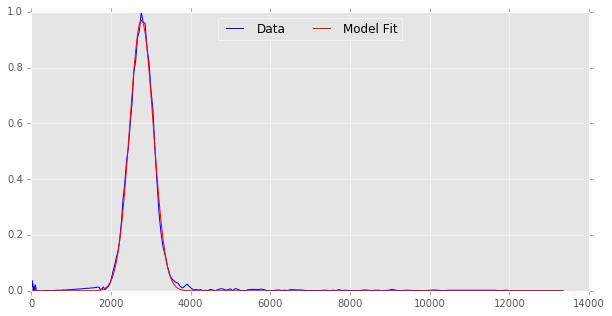

In [125]:
PlotData(fits)

---

## Custom functions

With the Model class, it is possible to write your own objective function, i.e. with convolutions, combinations etc.

Let's start with the convolution of a Gaussian and a Boltzmann. I want to fit only the temperature and the total amplitude, but none of the other stuff. This is something I did for the $T_1$ methyl data, where the impulsive reservoir is fixed while the statistical reservoir grows with excitation energy.

For this, I'm going to use a routine I've written that will do the convolution of two arrays, while returning the convolution result in the same dimensions as the input using a 1D interpolation.

---

In [197]:
def ConvolveGB(x, A, T):
    return A * ConvolveArrays(GaussianFunction(x, 1., 2300., 250.),       # None of the parameters are floated
                              BoltzmannFunction(x, 1., T),                # Only the temperature!
                              x)

So now we'll setup a new instance of Model, and we'll call it the "Triplet Model":

In [198]:
TripletModel = Model("Triplet Convolution")

 Please call SetFunction(Function)


In [199]:
TripletModel.SetFunction(ConvolveGB)

 Initialised variable dictionary:
{'A': None, 'T': None}


The instance method automatically detects which variables are actually required, making it quite trivial to set up new model functions to fit anything you want (in theory anyway).

In [203]:
TripletModel.SetVariables({"A": 100., "T": 10.})
TripletModel.SetBounds(([0., 0.],
                       [800., 10.]))

 Variables set to:	{'A': 100.0, 'T': 10.0}
 Boundary conditions set to:	([0.0, 0.0], [800.0, 10.0])


In [204]:
popt, report, fits, cov = FitModel(FC063b.Data, TripletModel)

 Curve fitting with:	Triplet Convolution
 Boundary Conditions:
([0.0, 0.0], [800.0, 10.0])
 Initial parameters:
{'A': 100.0, 'T': 10.0}
 ------------------------------------------------------
 Parameter Report:
            0
A  799.992382
T    0.318183


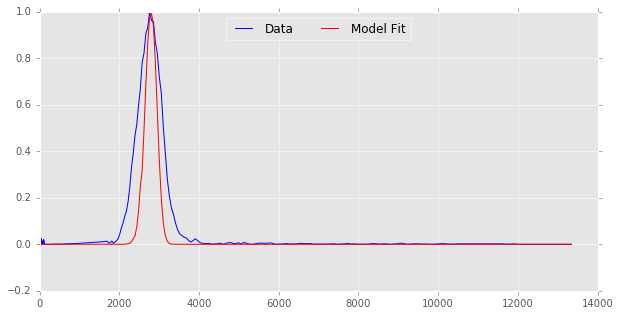

In [205]:
PlotData(fits)

In [206]:
np.diagonal(cov)

array([  1.08948754e+03,   5.04672799e-02])